In [58]:
# https://github.com/wiseodd/generative-models/tree/master/GAN 참조
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [69]:
# 설정값들 선언
b_size = 64 # batch size : 한번에 학습할 데이터 갯수
X_dim = 784     # real image size 28 x 28
z_dim = 64      # num_latent_variable
h_dim = 128     # hidden layer dimension size
lr =  1e-3       # learning rate
m = 5
lam = 1e-3      # lamda
gamma = 0.5     # diversity ratio
k_t = 0         # 

In [70]:
# MNIST 데이터 불러오기.
mnist = input_data.read_data_sets('data/mnist', one_hot=True)

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


In [71]:
# 생성된 MNIST 이미지를 4x4 Grid로 보여주는 plot 함수 정의
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [72]:
# xavier initialization : weight 초기화 방법 중 하나.
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [73]:
# Define placeholder 

X = tf.placeholder(tf.float32, shape=[None, X_dim]) # 실제 이미지 [60000, 784]
z = tf.placeholder(tf.float32, shape=[None, z_dim]) # input Latent Variable
k = tf.placeholder(tf.float32) # control value

In [74]:
# Generator 변수 설정  
# Hidden Layer parameter - weights & biases
G_W1 = tf.Variable(xavier_init([z_dim, h_dim])) # h_dim (Hidden Node) = 128 , z_dim = noise vector
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

# Output Layer parameter - weights & biases
G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

# Generator : Discriminator가 제대로 작동하지 않도록 실제 데이터와 유사한 가짜 데이터를 생성
# noise 데이터(128)를 input으로 받아 output 이미지 (784)생성
def G(z):
    G_h1 = tf.nn.relu((tf.matmul(z, G_W1) + G_b1))
    G_output = tf.nn.sigmoid(tf.matmul(G_h1, G_W2) + G_b2)   # output은 sigmoid(0~1사이)값
    return G_output

In [75]:
# Discriminator 변수 설정 
# Hidden Layer parameter - weights & biases
D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
# Output Layer parameter - weights & biases
D_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
D_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

# Discriminator : 실제 데이터와 생성된 가짜 데이터를 구별.
def D(X):
    D_h1 = tf.nn.relu(tf.matmul(X, D_W1) + D_b1) # 실제 이미지(X)가 input으로 들어감
    X_recon = tf.matmul(D_h1, D_W2) + D_b2  #   X_recon : Discriminator가 판단한 True(1) or Fake(0)
    return tf.reduce_mean(tf.reduce_sum((X - X_recon)**2, 1)) # discriminator의 최종 결과값은 얼마나 진짜와 가까운지를 판단. 

In [76]:
# make noise -> Latent Variable의 input으로 사용할 noise를 Uniform Distribution에서 batch_size만큼 샘플링
def sample_z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])  # 균등 분포 -1과 1사이에 랜덤값 추출. size : 랜덥값 배열들을 저장할 행(m:Test Sample Size) 열(n:Noise Dimension) 크기

In [77]:
# Generation, Loss, Optimization and Session Init.

# noise를 입력받아 가짜 이미지 생성
G_sample = G(z) 

# 진짜 이미지를 discriminator에 대입. 
D_real = D(X)  
# Reconstruct the fake images
D_fake = D(G_sample) 

# Discriminator/Generator loss 

D_loss = D_real - k*D_fake # D_loss : 얼마나 discriminator가 정확한가. 
G_loss = D_fake            # G_loss : 얼마나 D_fake가 진짜같은가

# Discriminator/Generator Optimizer

optim_D = (tf.train.AdamOptimizer(learning_rate=lr)
            .minimize(D_loss, var_list=[D_W1, D_W2, D_b1, D_b2]))
optim_G = (tf.train.AdamOptimizer(learning_rate=lr)
            .minimize(G_loss, var_list=[G_W1, G_W2, G_b1, G_b2]))

sess = tf.Session()
sess.run(tf.global_variables_initializer()) # 변수 초기화

<b><h2>Convergence measure</b></h2>

BEGAN에서는 equilibrium 개념을 가지고 global measure of convergence 제시.<p>
<img src="img/form2.png">
<h2><b>BEGAN의 objective function</b></h2><p>
<img src="img/form3.png">

Epochs: 0 Loss D: 237.6646,Loss G: 532.2933, Convergence measure: 651.12563324


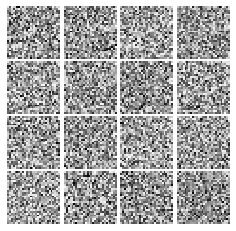

In [ ]:
# ********* Training and Testing
if not os.path.exists('out/'):
    os.makedirs('out/')  # make outputs folder

i = 0
num_epoch = 10000

for epoch in range(num_epoch): # 10000 = Num. of Epoch
    # MNIST 이미지를 batch_size만큼 불러온다. 
    batch_xs, _ = mnist.train.next_batch(b_size) 

    # Discriminator 최적화를 수행하고 Discriminator의 손실함수 return.
    _, D_real_curr = sess.run(
        [optim_D, D_real],
        feed_dict={X: batch_xs, z:  sample_z(b_size, z_dim), k: k_t}) 
    
    # Generator 최적화를 수행하고 Generator 손실함수 return.
    _, D_fake_curr = sess.run(
        [optim_G, D_fake],
        feed_dict={X: batch_xs, z: sample_z(b_size, z_dim)})
    
    # For balancing generator & discriminator loss.  discriminator가 얼마나  fake images에 집중할 것인지 컨트롤. 매 batch마다 업데이트.
    k_t = k_t + lam * (gamma*D_real_curr - D_fake_curr)   
    
    
    if epoch % 1000 == 0: # 1000 = Saving period
        # convergence measure
        measure = D_real_curr + np.abs(gamma * D_real_curr - D_fake_curr)
        # 1000번 반복할때마다 Discriminator의 손실함수와 Generator 손실함수 출력.
        print ("Epochs: %d Loss D: %.4f,Loss G: %.4f, Convergence measure: %.8f" % (epoch, D_real_curr, D_fake_curr, measure))
        
        samples = sess.run(G_sample, feed_dict={z:  sample_z(16, z_dim)})
        # 1000 epoch마다 image visulization
        fig = plot(samples)
        # 1000 epoch마다 생성되는 이미지를 out폴더에 저장
        plt.savefig('out/{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')                
        plt.show() 
        plt.close(fig)
        